In [26]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bayesianFunction import *

import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [27]:
data = pd.read_csv('data/train.csv')
data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)



[214]
[81]
13.4335837499051

Linear Regression Results:
Intercept: 8.9447
Relative error:  10.84%
Mean Squared Error: 27387.3336
R-squared: 0.9022


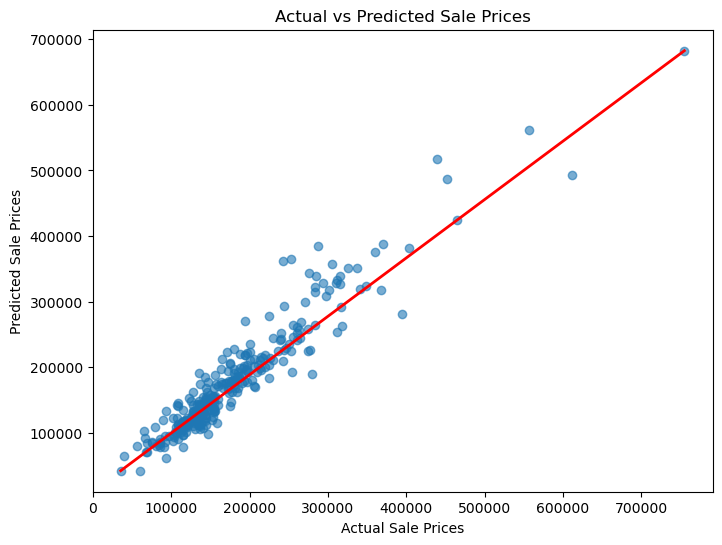

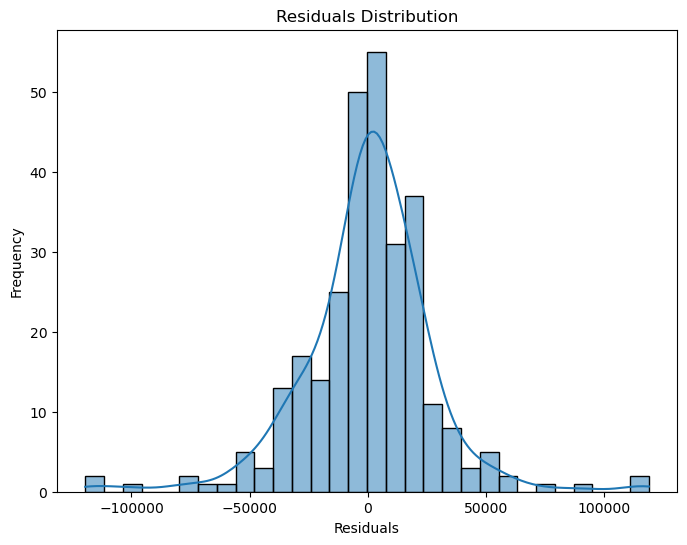

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

maxidx=np.where(y_pred == max(y_pred))[0]
minidx=np.where(y_pred == min(y_pred))[0]
print(maxidx)
print(minidx)
y_pred=np.delete(y_pred,maxidx)
y_pred=np.delete(y_pred,minidx)
y_test=np.delete(y_test,maxidx)
y_test=np.delete(y_test,minidx)

print(max(y_pred))


# 3. Model Performance and Diagnostics
print("\nLinear Regression Results:")
print(f"Intercept: {model.intercept_:.4f}")

ogytest=np.round(np.exp(y_test))
ogypred=np.exp(y_pred)
# Performance metrics
rmse = np.sqrt(mean_squared_error(ogytest, ogypred))
r2 = r2_score(ogytest, ogypred)
print(f"Relative error:  {get_relative_error(ogytest, ogypred)}%")

print(f"Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# 4. Compare Predictions with Actual Prices
plt.figure(figsize=(8, 6))
plt.scatter(ogytest, ogypred, alpha=0.6)
plt.plot([ogytest.min(), ogytest.max()],
         [ogypred.min(), ogypred.max()],
         color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices')
plt.show()

# 5. Residual Diagnostics
residuals = ogytest - ogypred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [29]:
data = pd.read_csv('data/train.csv')
data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)




Cross-Validation R-squared Scores:
[0.88936985 0.84990582 0.761863   0.90877185 0.88186026]
Mean R-squared (CV): 0.8584
Relative error:  10.3%

Lasso Regression Results:
Best Alpha: 0.001
Mean Squared Error (Log Scale): 25364.5803
R-squared: 0.9014


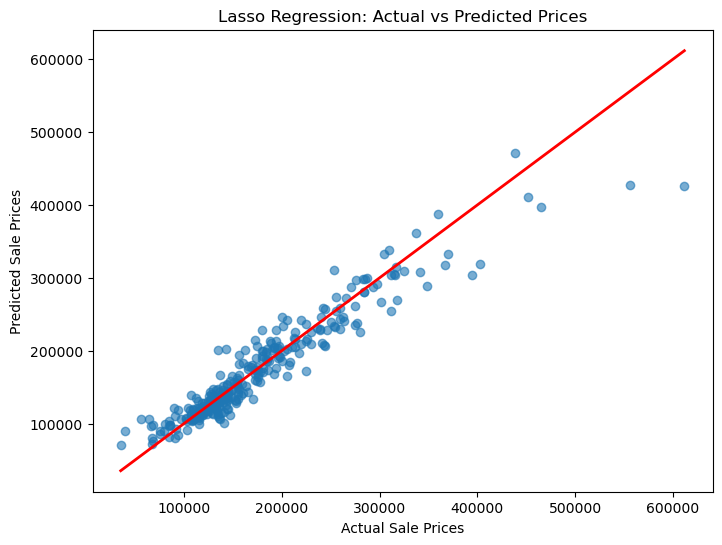


Top 10 Lasso Coefficients:
GrLivArea               0.100866
Neighborhood_StoneBr    0.092861
OverallQual             0.092068
Neighborhood_Crawfor    0.085583
Neighborhood_NridgHt    0.083775
Exterior1st_BrkFace     0.082066
CentralAir_Y            0.054231
Condition1_Norm         0.052964
Functional_Typ          0.052449
GarageCars              0.051795
dtype: float64


In [30]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}  # Regularization strengths
lasso_model = Lasso(max_iter=10000)  # Increase iterations for convergence
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Lasso model
best_lasso = grid_search.best_estimator_

# Cross-validation for evaluation
cv_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print("\nCross-Validation R-squared Scores:")
print(cv_scores)
print(f"Mean R-squared (CV): {np.mean(cv_scores):.4f}")


# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Back-transform predictions to original scale
y_pred_lasso_original = np.round(np.exp(y_pred_lasso))  # Revert log1p transformation
y_test_original = np.round(np.exp(y_test))

maxidx=np.where(y_pred_lasso_original == max(y_pred_lasso_original))[0]
minidx=np.where(y_pred_lasso_original == min(y_pred_lasso_original))[0]
y_pred_lasso_original=np.delete(y_pred_lasso_original,maxidx)
y_pred_lasso_original=np.delete(y_pred_lasso_original,minidx)
y_test_original=np.delete(y_test_original,maxidx)
y_test_original=np.delete(y_test_original,minidx)

# Evaluate performance
rmse_lasso = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
r2_lasso = r2_score(y_test_original, y_pred_lasso_original)
print(f"Relative error:  {get_relative_error(y_test_original, y_pred_lasso_original)}%")



print("\nLasso Regression Results:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (Log Scale): {rmse_lasso:.4f}")
print(f"R-squared: {r2_lasso:.4f}")

# Compare predictions with actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', lw=2)  # Ideal 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.show()

# Print top 10 non-zero coefficients
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)
top_10_coefficients = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False).head(10)
print("\nTop 10 Lasso Coefficients:")
print(top_10_coefficients)

